
# ¿Qué problemas son posibles resolver?

En este notebook aprenderemos a determinar *qué* problemas son abordables por heurísticas. En específico, veremos la diferencia en atacar los problemas polinomiales (P) y no determinísticos polinomiales (NP). En efecto, si $\pi$ es un problema NP-completo y encontramos una forma polinomial de resolverlo, habríamos probado unos de los problemas del milenio. 

Para este ejercicio trabajaremos con el problema del ***Minimum Spanning Tree***, utilizado frecuentemente en el problema del **vendedor viajero**. Dado un grafo ponderado no dirigido $R=(V,E,w)$ en un conjunto $V$ de vertices, $E$ de aristas con una función $w\to\mathbb{R}$ de pesos, buscamos un subgrafo **conectado**, **sin ciclos** cuyo peso total sea el **mínimo posible**. Su formulación simple es la siguiente: 

$$
\begin{align}
\min z&=\sum_{e\in E}w(e)x_e \\ \\
\sum_{e\in E}x_e&=\lvert V\rvert - 1\\ \\
\sum_{e\in E(S)}x_e&\leq\lvert S\rvert - 1\;\;\forall S\subseteq V, S\neq\emptyset\\ \\
x_e&\in\lbrace 0,1\rbrace\;\;\forall e\in E
\end{align}
$$

Por el otro lado, trabajaremos con la librería `networkx` para poder visualizar los problemas entre grafos. A continuación, un breve tutorial sobre cómo trabajar con aquella librería. Pueden saltar la sección en caso de saber dominarla.

## Utilización de networkx

`networkx` es una biblioteca de Python para estudiar grafos y analizar redes. Es ampliamente utilizado para distintos objetivos, entre ellos, visualizaciones, análisis de redes sociales o simulaciones. Es código abierto y mantenida activamente por una comunidad grande de programadores. 

### Creación de un grafo

Para poder crear un grafo, llamaremos a la función inicializadora

In [55]:
import networkx as nx

G = nx.Graph()

Es posible añadir nodos de varias formas. Para hacerlo, utilizaremos los siguientes métodos: 

- `add_node`: Añade un nodo singular, indexado por un ID que puede ser un string o entero.
- `add_nodes_from`: Añadir nodos a partir de una lista.


In [56]:
G.add_node(1)  # Añadir nodo con id "1"
G.add_node("A")  # Añadir nodo con id "A"
G.add_nodes_from([2, 3, 4])  # Añadir nodo a partir de una lista

De forma adicional, es posible añadir los nodos con el **id**, y **atributos** de una pasada directa. Los atributos pueden ser otorgados arbitrariamente por nosotros.

In [59]:
G.add_nodes_from(
    [
        (11, {"color": "red", "size": 20}),
        (12, {"color": "blue", "pos": (2.0, 5.0)}),
    ]
)

De la misma forma, es posible eliminar

In [20]:
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Obtenemos la red vial de Buenos Aires

In [31]:
ox.settings.use_cache = True
ox.settings.log_console = False

CITY = "Ciudad Autónoma de Buenos Aires, Argentina"
G = ox.graph_from_place(CITY, network_type="drive", simplify=True)

# Añade velocidades y tiempos (segundos); si falla, seguiremos con distancia
G = ox.add_edge_speeds(G)  # km/h estimado
G = ox.add_edge_travel_times(G)  # segundos

Utilizamos los puntos de interés. Algunos puntos interesantes que existen: 

- Restaurant
- Bank
- Cafe
- Toilets
- Telephone
- School
- Nightclub
- Pharmacy
- Police
- Vending_machine
- College

In [51]:
tags = {"amenity": "college"}
pois = ox.features_from_place(CITY, tags=tags)

# Elegimos los puntos de forma aleatoria
pois = pois[pois.geometry.type == "Point"].reset_index(drop=True)
CANTIDAD_PUNTOS = min(30, len(pois))
pois = pois.sample(CANTIDAD_PUNTOS, random_state=42).reset_index(drop=True)

# Coordenadas
lats = pois.geometry.y.values
lons = pois.geometry.x.values

# Acá obtenemos el nodo más cercano a los puntos de interés
poi_nodes = ox.nearest_nodes(G, lons, lats)

Aquí construimos el grafo hacia `networkx`

In [52]:
def pair_cost(u, v):
    try:
        # Intentamos añadir los costos por tiempo de viaje
        return nx.shortest_path_length(G, u, v, weight="travel_time")
    except Exception:
        return nx.shortest_path_length(G, u, v, weight="length")


K = nx.complete_graph(N)
# Añadimos los costos de cada camino
for i in range(N):
    for j in range(i + 1, N):
        w = pair_cost(poi_nodes[i], poi_nodes[j])
        K.add_edge(i, j, weight=w)

Visualizemos el grafo actual

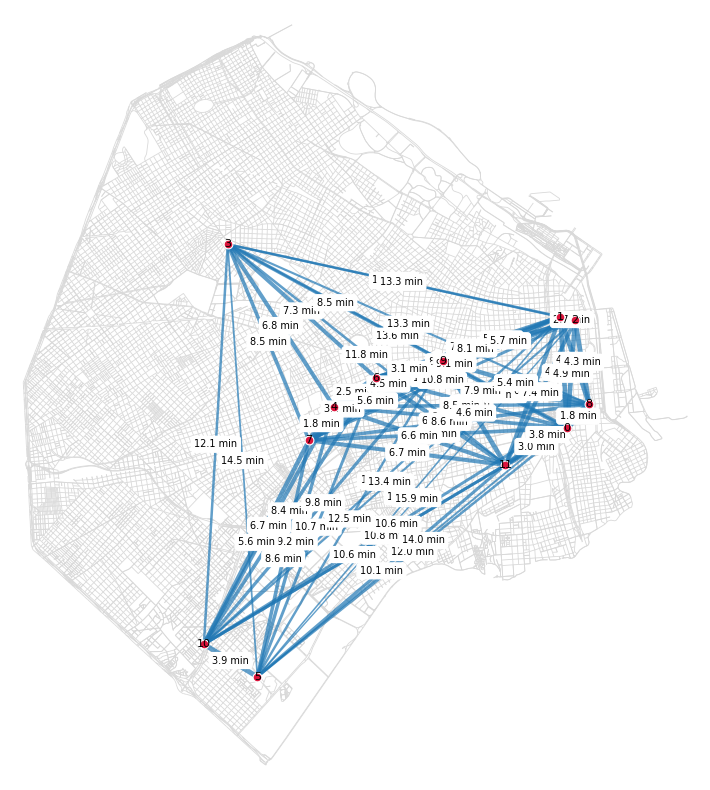

In [53]:
pos = {i: (G.nodes[poi_nodes[i]]["x"], G.nodes[poi_nodes[i]]["y"]) for i in range(N)}

# Acá definimos los anchos de las aristas, mientras más grande más grueso será el ancho de la arista
weights = [d["weight"] for _, _, d in K.edges(data=True)]
wmin, wmax = min(weights), max(weights)
eps = 1e-9
edge_widths = [1.0 + 3.0 * (wmax - w) / (wmax - wmin + eps) for w in weights]

# Etiquetas de las aristas
edge_labels = {(i, j): f"{K[i][j]['weight']/60:.1f} min" for i, j in K.edges()}

# Con esto graficamos el MAPA DE BUENOS AIRES. Esto no se relaciona
# con el network per se.
fig, ax = ox.plot_graph(
    G,
    node_size=0,
    edge_color="#d9d9d9",
    edge_linewidth=0.6,
    bgcolor="white",
    show=False,
    close=False,
)

# Dibujar el network:
# Notemos que networkx ya contiene métodos para poder graficar los vértices y nodos
nx.draw_networkx_edges(
    K, pos, ax=ax, width=edge_widths, edge_color="tab:blue", alpha=0.7
)
nx.draw_networkx_nodes(
    K,
    pos,
    ax=ax,
    node_size=40,
    node_color="crimson",
    edgecolors="white",
    linewidths=0.8,
)
nx.draw_networkx_labels(K, pos, ax=ax, font_size=8)

# Etiquetas de aristas
nx.draw_networkx_edge_labels(
    K, pos, ax=ax, edge_labels=edge_labels, font_size=7, rotate=False
)

plt.tight_layout()
plt.show()

In [34]:
try:
    method = nx.approximation.christofides
except AttributeError:
    method = "greedy"

order = nx.approximation.traveling_salesman_problem(
    K, cycle=True, weight="weight", method=method
)

In [35]:
route_nodes = []
for a_idx, b_idx in zip(order, order[1:]):
    a = poi_nodes[a_idx]
    b = poi_nodes[b_idx]
    path = nx.shortest_path(G, a, b, weight="travel_time")
    if route_nodes and route_nodes[-1] == path[0]:
        route_nodes.extend(path[1:])
    else:
        route_nodes.extend(path)

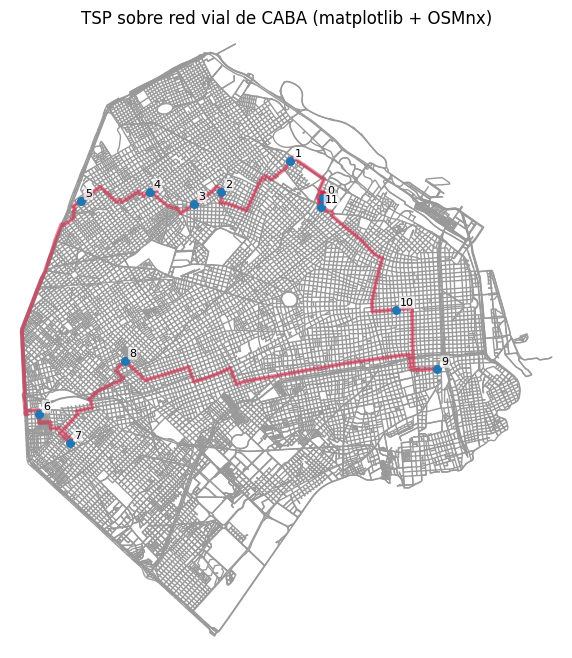

In [41]:
# ---------------------------------------------------------
# 7) Dibujo con matplotlib (OSMnx)
# ---------------------------------------------------------
fig, ax = ox.plot_graph_route(
    G,
    route_nodes,
    node_size=0,
    bgcolor="white",
    route_color="crimson",
    route_linewidth=3,
    show=False,
    close=False,
)

# Puntos de los POIs (coordenadas de los nodos más cercanos)
xs = [G.nodes[n]["x"] for n in poi_nodes]
ys = [G.nodes[n]["y"] for n in poi_nodes]
ax.scatter(xs, ys, s=30, marker="o", zorder=5)

# Etiquetas con el orden del tour (omitimos el último que repite el inicio)
for pos, idx in enumerate(order[:-1]):
    n = poi_nodes[idx]
    ax.annotate(
        str(pos),
        (G.nodes[n]["x"], G.nodes[n]["y"]),
        xytext=(3, 3),
        textcoords="offset points",
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.1", fc="white", ec="none", alpha=0.7),
        zorder=6,
    )

ax.set_title("TSP sobre red vial de CABA (matplotlib + OSMnx)", fontsize=12)
plt.show()

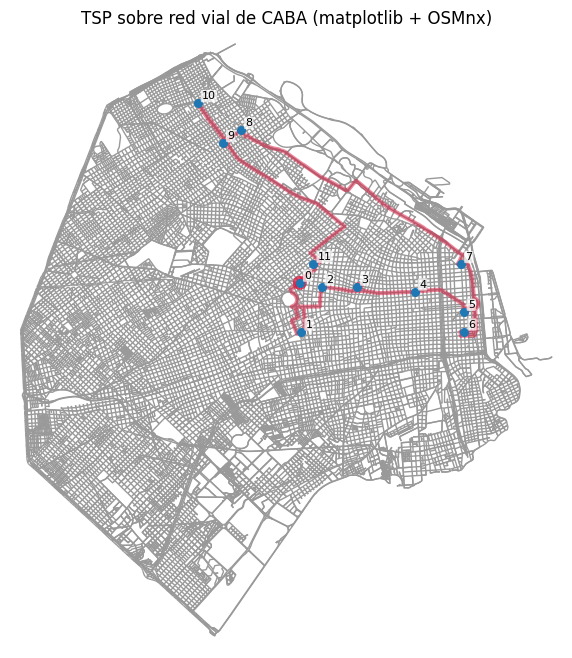

In [24]:
# !pip install osmnx networkx geopandas shapely

import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1) Red vial de Buenos Aires (CABA)
# ---------------------------------------------------------
ox.settings.use_cache = True
ox.settings.log_console = False

CITY = "Ciudad Autónoma de Buenos Aires, Argentina"
G = ox.graph_from_place(CITY, network_type="drive", simplify=True)

# Añade velocidades y tiempos (segundos); si falla, seguiremos con distancia
G = ox.add_edge_speeds(G)  # km/h estimado
G = ox.add_edge_travel_times(G)  # segundos

# ---------------------------------------------------------
# 2) POIs dentro de CABA (ej: cafés). Puedes cambiar los tags.
# ---------------------------------------------------------
tags = {"amenity": "cafe"}  # prueba: restaurant, pharmacy, bank, university, ...
pois = ox.features_from_place(CITY, tags=tags)

# Nos quedamos con puntos y muestreamos N
pois = pois[pois.geometry.type == "Point"].reset_index(drop=True)
N = min(12, len(pois))
pois = pois.sample(N, random_state=42).reset_index(drop=True)

# Coordenadas
lats = pois.geometry.y.values
lons = pois.geometry.x.values

# ---------------------------------------------------------
# 3) "Snapping" a la red: nodo más cercano para cada POI
# ---------------------------------------------------------
poi_nodes = ox.nearest_nodes(G, lons, lats)


# ---------------------------------------------------------
# 4) Grafo completo entre POIs con costo = tiempo de viaje (fallback a distancia)
# ---------------------------------------------------------
def pair_cost(u, v):
    try:
        return nx.shortest_path_length(G, u, v, weight="travel_time")
    except Exception:
        return nx.shortest_path_length(G, u, v, weight="length")


K = nx.complete_graph(N)
for i in range(N):
    for j in range(i + 1, N):
        w = pair_cost(poi_nodes[i], poi_nodes[j])
        K.add_edge(i, j, weight=w)

# ---------------------------------------------------------
# 5) Resolver TSP (ciclo). Usa Christofides si está disponible; sino greedy.
# ---------------------------------------------------------
try:
    method = nx.approximation.christofides
except AttributeError:
    method = "greedy"

order = nx.approximation.traveling_salesman_problem(
    K, cycle=True, weight="weight", method=method
)

# ---------------------------------------------------------
# 6) Convertir el tour de POIs a una ruta en la red vial real
# ---------------------------------------------------------
route_nodes = []
for a_idx, b_idx in zip(order, order[1:]):
    a = poi_nodes[a_idx]
    b = poi_nodes[b_idx]
    path = nx.shortest_path(G, a, b, weight="travel_time")
    if route_nodes and route_nodes[-1] == path[0]:
        route_nodes.extend(path[1:])
    else:
        route_nodes.extend(path)

# ---------------------------------------------------------
# 7) Dibujo con matplotlib (OSMnx)
# ---------------------------------------------------------
fig, ax = ox.plot_graph_route(
    G,
    route_nodes,
    node_size=0,
    bgcolor="white",
    route_color="crimson",
    route_linewidth=3,
    show=False,
    close=False,
)

# Puntos de los POIs (coordenadas de los nodos más cercanos)
xs = [G.nodes[n]["x"] for n in poi_nodes]
ys = [G.nodes[n]["y"] for n in poi_nodes]
ax.scatter(xs, ys, s=30, marker="o", zorder=5)

# Etiquetas con el orden del tour (omitimos el último que repite el inicio)
for pos, idx in enumerate(order[:-1]):
    n = poi_nodes[idx]
    ax.annotate(
        str(pos),
        (G.nodes[n]["x"], G.nodes[n]["y"]),
        xytext=(3, 3),
        textcoords="offset points",
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.1", fc="white", ec="none", alpha=0.7),
        zorder=6,
    )

ax.set_title("TSP sobre red vial de CABA (matplotlib + OSMnx)", fontsize=12)
plt.show()